# Demonstrating the Theil Index of Inequality:
## Spatial Inequality in Mexico: 1940-2000

This notebook demonstrates the application of the Theil Index of Inequality to decennial per-capita incomes in Mexico across its 32 states for the years 1940 to 2000.  The dataset is one that was used in the Rey & Sastre-Gutierrez paper titled "Interregional Inequality Dynamics in Mexico" (2010).

1. Imports & Input Data
2. Classic Theil Index
3. Theil Regional Inequality Decomposition

-------------------------

### Imports & Input Data

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2024-12-01T16:48:37.972958-08:00

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.29.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 21.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit



In [2]:
import geopandas
import inequality
import libpysal
import matplotlib.pyplot as plt
import numpy

2.5
2.5
2.5


In [3]:
%watermark -w
%watermark -iv

Watermark: 2.5.0

geopandas : 1.0.1
numpy     : 2.1.2
inequality: 0.1.dev174+g5025e73
libpysal  : 4.12.1
matplotlib: 3.9.2



In [4]:
libpysal.examples.explain("mexico")

mexico

Decennial per capita incomes of Mexican states 1940-2000
--------------------------------------------------------

* mexico.csv: attribute data. (n=32, k=13)
* mexico.gal: spatial weights in GAL format.
* mexicojoin.shp: Polygon shapefile. (n=32)

Data used in Rey, S.J. and M.L. Sastre Gutierrez. (2010) "Interregional inequality dynamics in Mexico." Spatial Economic Analysis, 5: 277-298.



In [5]:
pth = libpysal.examples.get_path("mexicojoin.shp")
gdf = geopandas.read_file(pth)

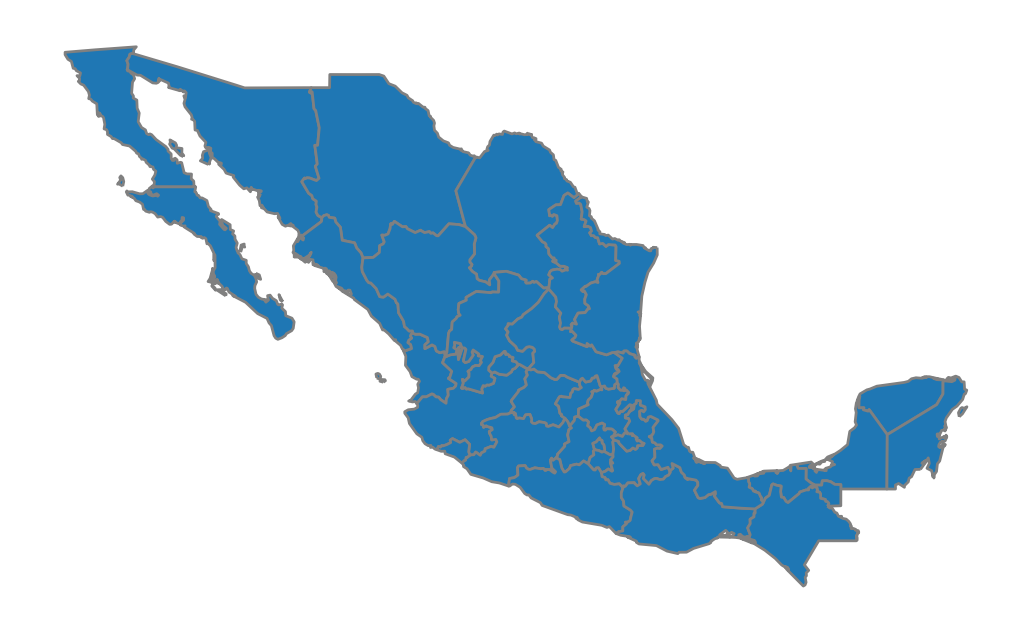

In [6]:
#| label: fig-mexico
#| fig-cap: "Map of Mexico with outlines of the 32 states"

ax = gdf.plot(edgecolor='grey')
ax.set_axis_off()

In [7]:
gdf.head()

POLY_ID          AREA  CODE                   NAME    PERIMETER  \
0        1  7.252751e+10  MX02  Baja California Norte  2040312.385   
1        2  7.225988e+10  MX03    Baja California Sur  2912880.772   
2        3  2.731957e+10  MX18                Nayarit  1034770.341   
3        4  7.961008e+10  MX14                Jalisco  2324727.436   
4        5  5.467030e+09  MX01         Aguascalientes   313895.530   

          ACRES     HECTARES  PCGDP1940  PCGDP1950  PCGDP1960  ...  GR9000  \
0  1.792187e+07  7252751.376    22361.0    20977.0    17865.0  ...    0.05   
1  1.785573e+07  7225987.769     9573.0    16013.0    16707.0  ...    0.00   
2  6.750785e+06  2731956.859     4836.0     7515.0     7621.0  ...   -0.05   
3  1.967200e+07  7961008.285     5309.0     8232.0     9953.0  ...    0.03   
4  1.350927e+06   546702.985    10384.0     6234.0     8714.0  ...    0.13   

   LPCGDP40  LPCGDP50  LPCGDP60  LPCGDP70  LPCGDP80  LPCGDP90  LPCGDP00  TEST  \
0      4.35      4.32      4.25      4.40      4.47      4.43      4.48   1.0   
1      3.98      4.20      4.22      4.39      4.46      4.41      4.42   2.0   
2      3.68      3.88      3.88      4.04      4.13      4.11      4.06   3.0   
3      3.73      3.92      4.00      4.21      4.32      4.30      4.33   4.0   
4      4.02      3.79      3.94      4.21      4.32      4.32      4.44   5.0   

                                            geometry  
0  MULTIPOLYGON (((-113.13972 29.01778, -113.2405...  
1  MULTIPOLYGON (((-111.20612 25.80278, -111.2302...  
2  MULTIPOLYGON (((-106.62108 21.56531, -106.6475...  
3  POLYGON ((-101.5249 21.85664, -101.5883 21.772...  
4  POLYGON ((-101.8462 22.01176, -101.9653 21.883...  

[5 rows x 35 columns]

Before we begin, let's set the stage by examining the quantiles for per-capita GDP by state in 1969.  We will use quintiles (choosing 5 as our value of "k" in the plot function below) on the PCGDP1960 column from the Mexico geodataframe in the previous cell.  Darker colors signify less wealthy states, and brighter colors signify more wealthy states.

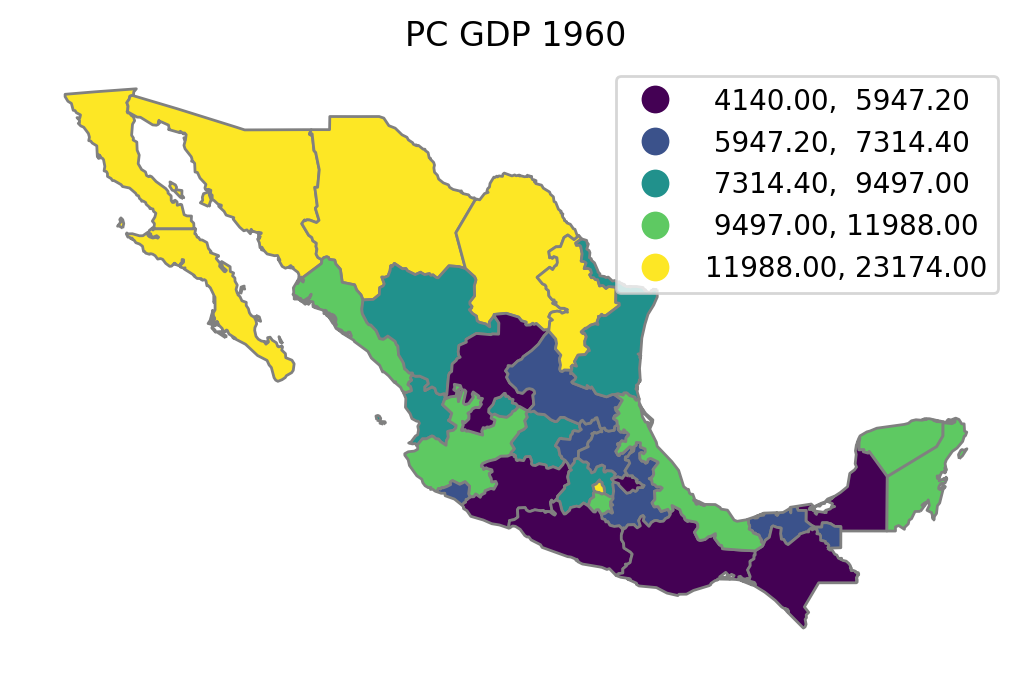

In [8]:
#| label: fig-quantiles
#| fig-cap: "States of Mexico showing quintiles for Per-Capita GDP from 1969."

ax = gdf.plot(column="PCGDP1960", k=5, scheme="Quantiles", 
              edgecolor='grey',legend=True)
ax.set_axis_off()
ax.set_title("PC GDP 1960");
# plt.savefig("1940.png")

------------------------------------------------

### Classic Theil Coefficient

The Theil index is another major statistic used to measure economic inequality across regions or countries, similar to the Gini index.  Its value ranges from zero to positive infinity, where zero represents equal distribution and higher values represent a higher level of inequality.  Furthermore, the index can be broken down into two components.  The first is for the disparities within subgroups ("intraregional" component), and the second is for the disparities between subgroups ("interregional" component).  In our case, the subgroups will be five predefined clusters ("regions") of states within Mexico.  

Source: OECD (2016), OECD Regions at a Glance 2016, OECD Publishing, Paris, https://doi.org/10.1787/reg_glance-2016-en.

First, let's calculate the composite Theil index for the states of Mexico in 1969.

In [9]:
theil_1940 = inequality.theil.Theil(gdf["PCGDP1960"])
theil_1940.T

0.10472941488245859

--------------------------------------

### Theil Regional Inequality Decomposition

In [10]:
inequality.theil.TheilD

inequality.theil.TheilD

For our Theil application, we will use a clustering scheme for the Mexican states taken from a prior study done by Hanson in 1998, referenced in the Rey & Sastre-Gutierrez paper titled "Interregional Inequality Dynamics in Mexico" (2010).  The "HANSON98" column from the Mexico geodataframe assigns each state to a cluster (five in total). See @fig-hanson below for the cluster assignments.

In [11]:
regimes = gdf["HANSON98"]

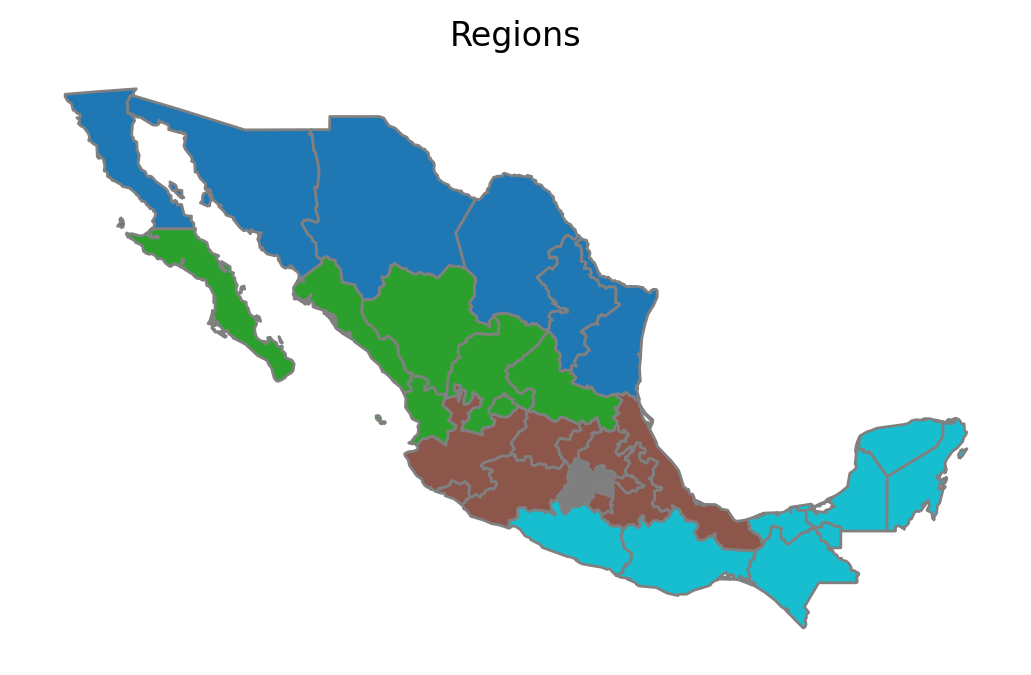

In [12]:
#| label: fig-hanson
#| fig-cap: "States of Mexico grouped into clusters based on the Hanson 1998 study."

ax = gdf.plot(column="HANSON98", categorical=True,
             edgecolor='grey')
ax.set_title("Regions")
ax.set_axis_off()
# plt.savefig("regions.png")

We calculate the overall Theil inequality index for the year 1969 based on the PCGDP1960 column using the Hanson-defined regions.  We access it using `T`.

In [13]:
numpy.random.seed(12345)
ts = inequality.theil.TheilD(gdf['PCGDP1960'], regimes)

In [14]:
ts.T

0.10472941488245859

We can then access the between-group and within-group components using the `bg` and `wg` attributes, respectively.

In [15]:
ts.bg

array([0.05260921])

In [16]:
ts.wg

array([0.0521202])

A measure of *spatial polarization* is obtained as the ratio of the `bg` component to overall inequality `T`:


In [17]:
ts.bg[0] / ts.T

np.float64(0.5023346581367524)

In other words, inequality between the regions accounts for just over 50 percent of overall inequality between the states in Mexico in 1969.

This leads to a question of how to interpret this polarization measure. One way to answer this, is to compare this value against that obtained from a random distribution. That is, does the assignment of states to the regions actually matter?

### Inference on inequality decomposition

We address the inference question by randomly assigning states to the regions. This is done though a random permutation of the 32 states. We repeat this random permutation a large number of times, and for each random permutation we calculate the decomposition. Since the random permutations are the counterfactuals where state incomes were random in space, this gives us a distribution of the between group (region) component under the null.



In [18]:
import numpy as np
np.random.seed(10)

In [19]:
ts = inequality.theil.TheilDSim(gdf['PCGDP1960'], regimes, permutations=999)

In [20]:
ts.bg_pvalue

array([0.001])

The p-value is a pseudo p-value obtained as the share of all realizations (including the observed realization) that generated `bg` values as large as the one observed. Since we asked for 999 permutations, our p-value indicates that none of the counterfactual realizations generated values as large as what we observed. 

In [21]:
import seaborn as sbn

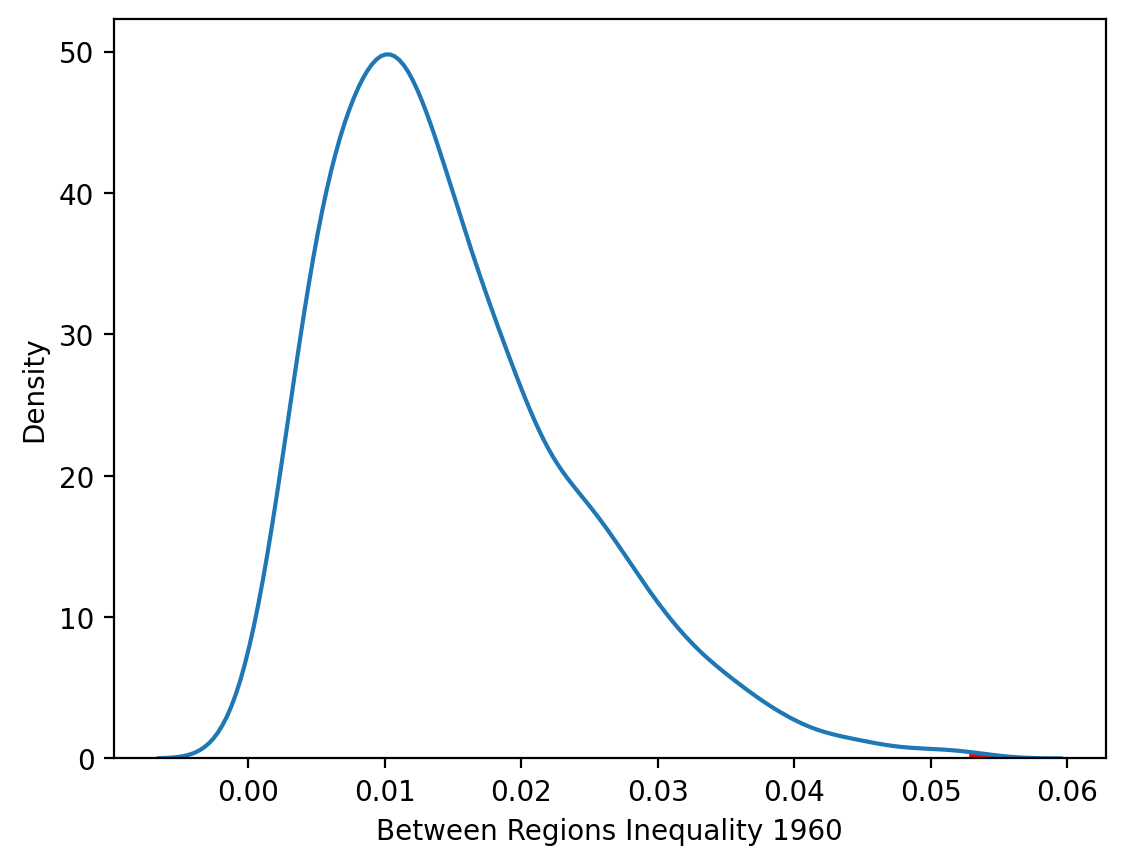

In [22]:
import matplotlib.pyplot as plt
kdeplot = sbn.kdeplot(ts.bg, fill=False, legend=False)
x_vals = kdeplot.lines[0].get_xdata()
y_vals = kdeplot.lines[0].get_ydata()
plt.fill_between(x_vals, y_vals, where=(x_vals > ts.bg[0]), color='red')
plt.xlabel('Between Regions Inequality 1960');

-----------------------

## Dynamics of Regional Inequality

Lastly, we examine how the regional inequality in Mexico has changed over time.  We will calculate the end-of-decade Theil indices using the `PCGDP%s` columns as indicated in the code below where `s` is each start-of-decade year ranging from 1940 through 2000 inclusive.  The resulting values will be the indices for the years 1949, 1959, 1969, 1979, 1989, 1999, and 2009 in that order.

In [23]:
decades = range(1940, 2010, 10)
decades

ts = [inequality.theil.Theil(gdf["PCGDP%s" % decade]).T for decade in decades]
ts

[0.20894344230358597,
 0.1522245052653124,
 0.10472941488245859,
 0.10194724969688375,
 0.09560112758525614,
 0.1051125639798185,
 0.10660832349588023]

The results show that the regional inequality started rather high at the end of the 1940s, then declined over two decades (1950s and 1960s), and remained steady through 2009.